In [45]:
# !pip install -Uqqq dabl
# !pip install -Uqqq pycaret
# !pip install -qqq wandb
# -Uqqq will install any library without giving any ugly outputs
# -U stands for Upgrade and each each q in qqq is used to silence WARNING, ERROR, and CRITICAL logging levels respectively

import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.ensemble import ExtraTreesClassifier
import pickle

import tensorflow as tf
from tensorflow.keras import layers, models

# show all columns in a df while using functions like .head()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# to reset option use: pd.reset_option('max_columns')
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

def add_spines(colour = '#2d6383', linewidth = 2, heatmap=False):
    """
    Add beautiful spines to you plots
    """
    ax = plt.gca()
    ax.spines[['bottom', 'left', 'top', 'right']].set_visible(True)
    if heatmap==True:
        ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['bottom', 'left', 'top', 'right']].set_color(colour)
    ax.spines[['bottom', 'left', 'top', 'right']].set_linewidth(linewidth)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/higgs-boson/training.zip
/kaggle/input/higgs-boson/HiggsBosonCompetition_AMSMetric_rev1.py
/kaggle/input/higgs-boson/random_submission.zip
/kaggle/input/higgs-boson/test.zip


In [4]:
df = pd.read_csv('/kaggle/input/higgs-boson/training.zip', low_memory=False)
test = pd.read_csv('/kaggle/input/higgs-boson/test.zip', low_memory=False)
print('Train shape: ', df.shape)
print('Test shape: ', test.shape)

Train shape:  (250000, 33)
Test shape:  (550000, 31)


In [4]:
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [6]:
df['Label'].value_counts()
# the target variable is relatively balanced, removing the need of any oversampling or undersampling

Label
b    164333
s     85667
Name: count, dtype: int64

In [4]:
def color_true_false(val):
    color = 'background-color: #aafac9' if val else 'background-color: #cfeffa'
    return color

import dabl
result = dabl.detect_types(df)
result.style.applymap(color_true_false)

,continuous,dirty_float,low_card_int_ordinal,low_card_int_categorical,categorical,date,free_string,useless
EventId,True,False,False,False,False,False,False,False
DER_mass_MMC,True,False,False,False,False,False,False,False
DER_mass_transverse_met_lep,True,False,False,False,False,False,False,False
DER_mass_vis,True,False,False,False,False,False,False,False
DER_pt_h,True,False,False,False,False,False,False,False
DER_deltaeta_jet_jet,True,False,False,False,False,False,False,False
DER_mass_jet_jet,True,False,False,False,False,False,False,False
DER_prodeta_jet_jet,True,False,False,False,False,False,False,False
DER_deltar_tau_lep,True,False,False,False,False,False,False,False
DER_pt_tot,True,False,False,False,False,False,False,False


[]

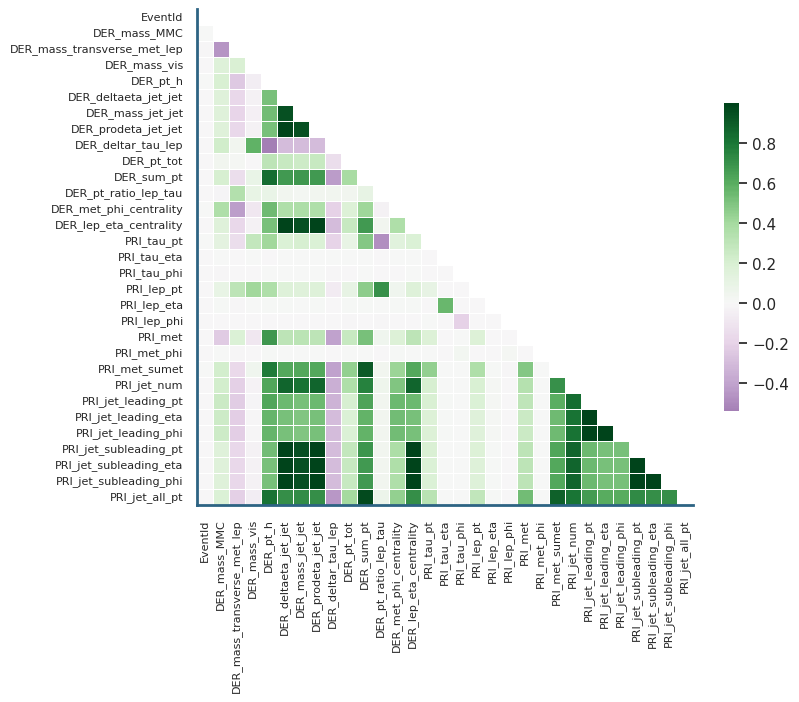

In [104]:
corr=df.drop(['Label', 'Weight'], axis=1).corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='PRGn', center=0,
            square=True, linewidths=.7, cbar_kws={"shrink": .5})
add_spines(linewidth=2, heatmap=True)
plt.xticks(fontsize=8, rotation=90) 
plt.yticks(fontsize=8) 
plt.plot()

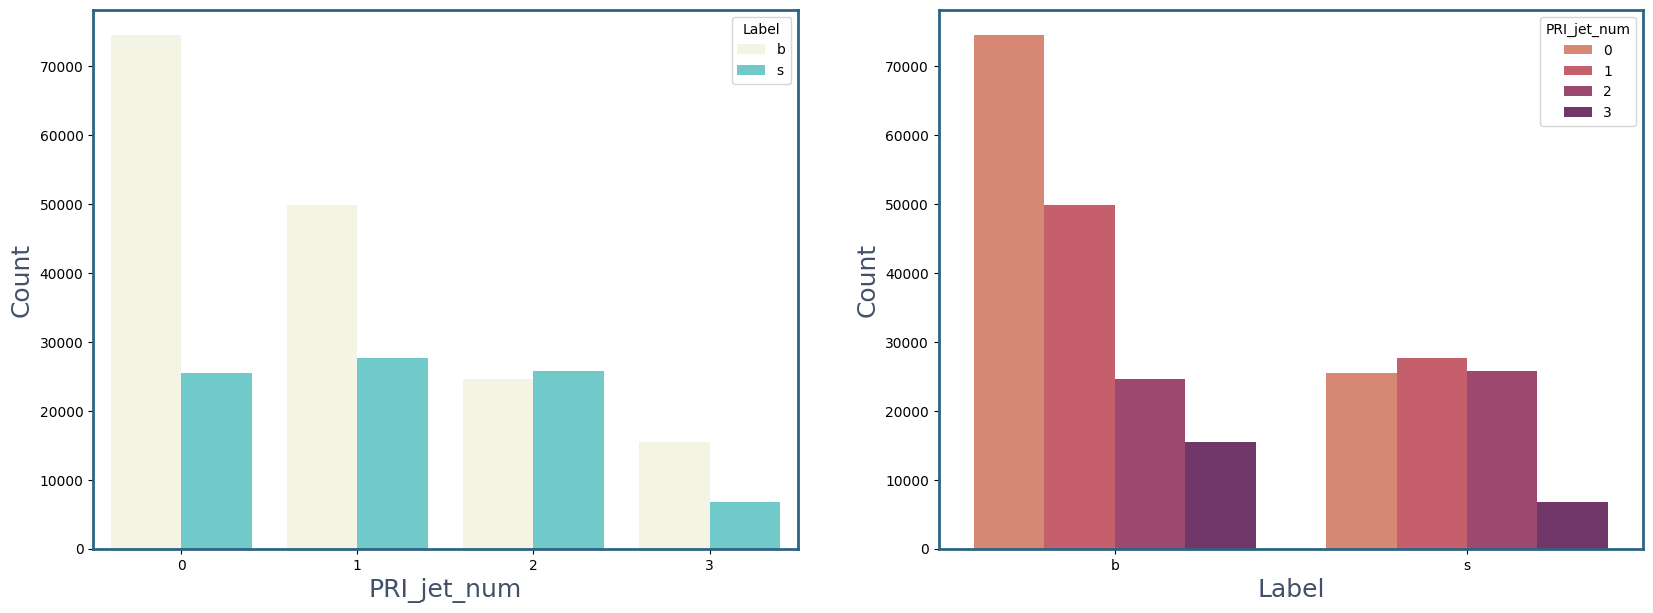

In [19]:
plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
segment = df.replace(-999, np.nan).groupby(['PRI_jet_num', 'Label']).EventId.count().reset_index()
sns.barplot(data=segment, x='PRI_jet_num', y='EventId', hue='Label', palette = {"s": "#63d8d8", "b": "#f7f7e1"})
add_spines(linewidth=2)
plt.xlabel('PRI_jet_num', fontsize= 18).set_color('#425169')
plt.ylabel('Count', fontsize= 18).set_color('#425169')

plt.subplot(1, 2, 2)
segment = df.replace(-999, np.nan).groupby(['Label', 'PRI_jet_num']).EventId.count().reset_index()
sns.barplot(data=segment, x='Label', y='EventId', hue='PRI_jet_num', palette = 'flare')
plt.ylabel('Count')
add_spines(linewidth=2)
plt.xlabel('Label', fontsize= 18).set_color('#425169')
plt.ylabel('Count', fontsize= 18).set_color('#425169')
# distribution of number of jets over the signal events is flatter compared to that of background

In [37]:
sns.set_theme(style="white")
def violin(n, y, top, bottom):
    plt.subplot(2, 3, n+1)
    sns.violinplot(data=df.replace(-999, np.nan), x='PRI_jet_num', y=y, hue="Label",
                   split=True, inner="quart", palette={"s": "#63d8d8", "b": "#f7f7e1"})
    add_spines(colour= '#275773', linewidth=1)
    if top is not None:  
        plt.ylim(top=top, bottom=bottom)

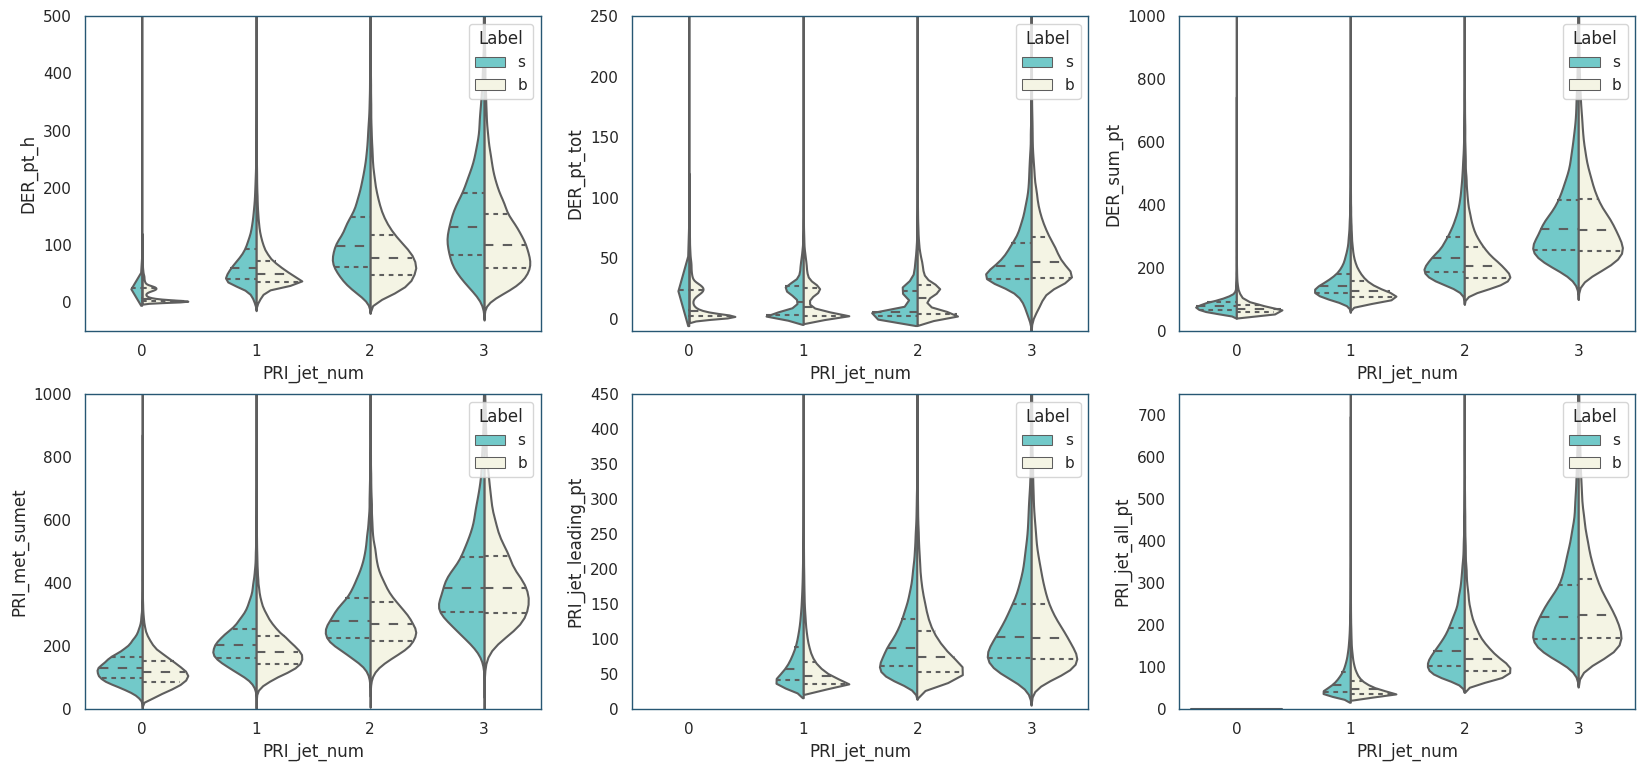

In [38]:
plt.figure(figsize=(20, 9))
columns_selected = [("DER_pt_h", 500, -50),("DER_pt_tot", 250, -10),("DER_sum_pt", 1000, 0),("PRI_met_sumet", 1000, 0),("PRI_jet_leading_pt", 450, 0),("PRI_jet_all_pt", 750, 0)]
for n, y in enumerate(columns_selected):
    violin(n, y[0], y[1], y[2])

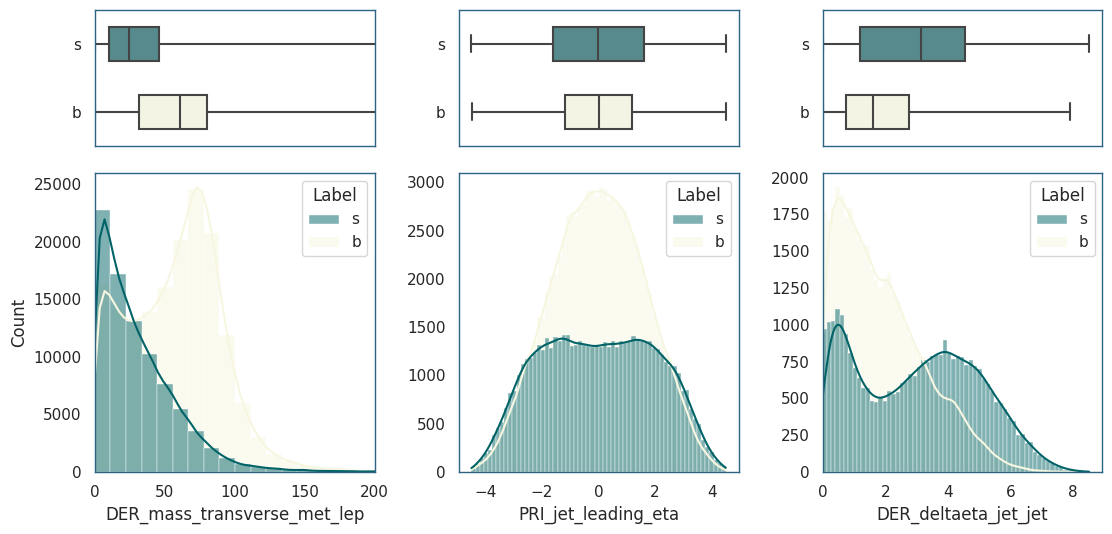

In [113]:
sns.set_theme(style="white")
fig = plt.figure(figsize=(13, 6))
grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.2, figure = fig)
def rem_xaxis():
    plt.xlabel('')
    plt.xticks([])
def rem_yaxis():
    plt.ylabel('')
#     plt.yticks([])
    

plt.subplot(grid[0, 0])
sns.boxplot(data=df.replace(-999, np.nan), x="DER_mass_transverse_met_lep", y="Label", palette = {"s": "#4d9295", "b": "#f7f7e1"}, width=.5, whis=(0, 100))
add_spines(linewidth=1)
rem_xaxis()
rem_yaxis()
plt.xlim(right=200, left=0)

plt.subplot(grid[0, 1])
sns.boxplot(data=df.replace(-999, np.nan), x="PRI_jet_leading_eta", y="Label", palette = {"s": "#4d9295", "b": "#f7f7e1"}, width=.5, whis=(0, 100))
add_spines(linewidth=1)
rem_xaxis()
rem_yaxis()

plt.subplot(grid[0, 2])
sns.boxplot(data=df.replace(-999, np.nan), x="DER_deltaeta_jet_jet", y="Label", palette = {"s": "#4d9295", "b": "#f7f7e1"}, width=.5, whis=(0, 100))
add_spines(linewidth=1)
rem_xaxis()
rem_yaxis()
plt.xlim(left=0)

plt.subplot(grid[1:, 0])
sns.histplot(data=df.replace(-999, np.nan), x="DER_mass_transverse_met_lep", kde=True, hue='Label', palette = {"s": "#016367", "b": "#f7f7e1"}, bins = math.floor(len(df)**(1/3)))
add_spines(linewidth=1)
plt.xlim(right=200, left=0)

plt.subplot(grid[1:, 1])
sns.histplot(data=df.replace(-999, np.nan), x="PRI_jet_leading_eta", kde=True, hue='Label', palette = {"s": "#016367", "b": "#f7f7e1"}, bins = math.floor(len(df)**(1/3)))
add_spines(linewidth=1)
rem_yaxis()

plt.subplot(grid[1:, 2])
sns.histplot(data=df.replace(-999, np.nan), x="DER_deltaeta_jet_jet", kde=True, hue='Label', palette = {"s": "#016367", "b": "#f7f7e1"}, bins = math.floor(len(df)**(1/3)))
plt.xlim(left=0)
add_spines(linewidth=1)
rem_yaxis()